### imports

In [1]:
!pip install tensorflow
!pip install gensim

In [4]:
import tensorflow as tf

from gensim.models import Word2Vec
from gensim.models import LsiModel
import gensim

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### prepare dataset

In [81]:
import json
import contractions

def pad_sequence(dataset):
    max_len = len(max(dataset, key=len))
    print("max length of MWO:", max_len)
    for i in range(len(dataset)):
        count = 0
        while len(dataset[i]) < max_len:
            dataset[i].append(dataset[i][count])
            count+=1
    return dataset

def add_inherent_functions(row):
    for e in row["entities"]:
        tokens = row["tokens"]
        entity_type = e["type"].split("/")
        if entity_type[0] == "PhysicalObject":
            if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                if entity_type[1][:-6].lower() not in tokens:
                    tokens.append(entity_type[1][:-6].lower())
                # tokens.append(entity_type[1][-6:].lower())
    return tokens

    # BROKEN CODE
    # physical_object_indices = []
    # 
    # for e in row["entities"]:
    #     new_list = row["tokens"]
    #     entity_type = e["type"].split("/")
    #     if entity_type[0] == "PhysicalObject":
    #         if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
    #             new_string = " ".join(new_list)
    #             if e["end"] == len(row["tokens"]):
    #                 replace_index = new_string.find(" ".join(row["tokens"][e["start"]:]))
    #                 new_string = new_string.replace(" ".join(row["tokens"][e["start"]:]))
    #             else:
    #                 replace_index = new_string.find(" ".join(row["tokens"][e["start"]:e["end"]]))
    #                 new_string = new_string.replace(" ".join(row["tokens"][e["start"]:e["end"]]), "")
    #             new_string = new_string[replace_index:]
    #             new_list = new_string.split()
    #             physical_object_indices.append((e["start"], e["end"], entity_type[1]))
    # for i in physical_object_indices:
    #     if i[1] == len(row["tokens"]):
    #         row["tokens"].append(i[2])
        

def clean_tokens(tokens):
    stopwords =["<num>", "<id>", "-"]
    tokens = [i for i in tokens if i not in stopwords]
    tokens = contractions.fix(" ".join(tokens)).split()
    return tokens

def prepare_dataset(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    dataset = []

    for datum in data:
        keep_indices = []
        for entity in datum["entities"]:
            if entity["type"].split("/")[0] not in ["PhysicalObject", "Activity"]:
                start = entity["start"]
                end = entity["end"]
                for i in range(start, end):
                    keep_indices.append(i)

        tokens = []
        for i in sorted(set(keep_indices)):
            tokens.append(datum["tokens"][i])
        
        tokens = clean_tokens(tokens)
        if tokens:
            dataset.append(" ".join(tokens))
    # dataset = pad_sequence(dataset)
    return dataset

def full_dataset(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    d = []

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            tokens = clean_tokens(datum["tokens"])
            # d.append(" ".join(tokens))
            d.append(tokens)
    # d = pad_sequence(dataset)
    return d

def full_dataset_append_inherent_functions(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    d = []

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            tokens = add_inherent_functions(datum)
            tokens = clean_tokens(tokens)
            # d.append(" ".join(tokens))
            d.append(tokens)
    return d

# OG dataset

## CNN

In [31]:
dataset = full_dataset("../data/gold_release.json")
print(dataset)
pad_sequence(dataset)
print(len(dataset))

[['air', 'conditioner', 'thermostat', 'not', 'working'], ['air', 'conditioner', 'thermostat', 'unserviceable'], ['air', 'conditioner', 'unserviceable'], ['air', 'conditioner', 'unserviceable', 'when', 'stationary'], ['air', 'conditioner', 'warm'], ['air', 'filters', 'plugged'], ['air', 'horn', 'disconnected'], ['air', 'horn', 'does', 'not', 'work'], ['air', 'horn', 'fault'], ['air', 'horn', 'not', 'working'], ['air', 'horn', 'not', 'working', 'compressor', 'awaiting'], ['air', 'horn', 'stuck', 'on'], ['air', 'horn', 'unserviceable'], ['air', 'horn', 'working', 'intermittently'], ['air', 'leak'], ['air', 'leak', 'near', 'side', 'of', 'door'], ['air', 'leaking', 'from', 'line', 'outside'], ['airhorn', 'not', 'working'], ['alarm', 'on', 'VIMS', 'does', 'not', 'work'], ['all', 'dash', 'lights', 'on'], ['alternator', 'drive', 'leaking'], ['alternator', 'failed'], ['alternator', 'not', 'charging'], ['alternator', 'overcharge', 'fault'], ['alternator', 'overcharged'], ['analyse', 'failed', 'd

In [32]:
# Word2Vec embeddings as input
w2vmodel = gensim.models.Word2Vec(dataset, min_count=1, vector_size=100,
                                window=5, sg=1)
w2v_embeddings = []
for sentence in dataset:
    row = []
    for word in sentence:
        row.append(w2vmodel.wv[word])
    w2v_embeddings.append(row)
w2v_embeddings = np.array(w2v_embeddings)

In [33]:
print(w2v_embeddings.shape)
shape = w2v_embeddings.shape
w2v_embeddings=w2v_embeddings.reshape(shape[0], shape[1], shape[2], 1)
print(w2v_embeddings.shape)


(540, 11, 100)
(540, 11, 100, 1)


In [34]:
# LSI embeddings as output
dictionary = gensim.corpora.Dictionary(dataset)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dataset]
lsamodel = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
concepts = list(lsamodel[doc_term_matrix])
lsa_embeddings=[]
for i in concepts:
    row = []
    for j in i:
        row.append(j[1])
    lsa_embeddings.append(row)
lsa_embeddings = np.array(lsa_embeddings)

In [35]:
print(lsa_embeddings.shape)
print(lsa_embeddings)

(540, 10)
[[-3.12075413e+00  2.08368859e+00  1.10207835e+00 ... -4.64416505e-01
  -5.55591415e-01 -1.02659037e+00]
 [-3.51363095e+00  2.00534915e+00  1.28011154e+00 ...  6.93348986e-01
  -4.77963534e-02  8.89669269e-01]
 [-4.66025705e+00  2.60422975e+00  1.70223810e+00 ...  1.08451840e+00
  -4.94114689e-02  1.36370976e+00]
 ...
 [-6.17537347e-01  1.66026978e-01  3.97163030e-01 ...  1.11454067e+00
  -3.74019082e-01  7.72857424e-01]
 [-3.42717219e-01 -2.28467990e-01 -5.97170357e-01 ... -9.28871653e-02
  -1.65512352e+00  3.49970369e-02]
 [-6.23103839e-01 -4.90451949e-03  3.66664227e-01 ...  1.70858074e+00
   4.33639853e-03  1.92894338e+00]]


In [36]:
dr = 10
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(11,100,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dr, activation="tanh"),
    tf.keras.layers.Dense(units=10, activation="tanh")
])


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 11, 100, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 50, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 50, 8)       │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        20,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,720 (80.94 KB)

 Trainable params: 20,720 (80.94 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanSquaredLogarithmicError("sum_over_batch_size"),
              metrics=['accuracy'])

history = model.fit(w2v_embeddings, lsa_embeddings, epochs=200)


Epoch 1/200


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0749 - loss: 0.0857
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1513 - loss: 0.0698
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1352 - loss: 0.0776
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1102 - loss: 0.0752
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1692 - loss: 0.0763
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1895 - loss: 0.0795
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1511 - loss: 0.0711
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1424 - loss: 0.0674
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1891 - loss: 0.0693
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1753 - loss: 0.0661
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2215 - loss: 0.0642
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2117 - lo

[0.05740740895271301, 0.1259259283542633, 0.12777778506278992, 0.13333334028720856, 0.13703703880310059, 0.21296297013759613, 0.14814814925193787, 0.15555556118488312, 0.1944444477558136, 0.1814814805984497, 0.2222222238779068, 0.2518518567085266, 0.24259258806705475, 0.25, 0.2666666805744171, 0.3055555522441864, 0.28518518805503845, 0.3203703761100769, 0.34259259700775146, 0.32407405972480774, 0.37962964177131653, 0.3740740716457367, 0.32592591643333435, 0.31481480598449707, 0.364814817905426, 0.34259259700775146, 0.37037035822868347, 0.38333332538604736, 0.43888887763023376, 0.42407408356666565, 0.442592591047287, 0.4296296238899231, 0.46296295523643494, 0.43703705072402954, 0.4314814805984497, 0.4592592716217041, 0.442592591047287, 0.47777777910232544, 0.4888888895511627, 0.49444442987442017, 0.47777777910232544, 0.49074074625968933, 0.529629647731781, 0.5092592835426331, 0.5018518567085266, 0.5277777910232544, 0.5055555701255798, 0.550000011920929, 0.5574073791503906, 0.54444444179

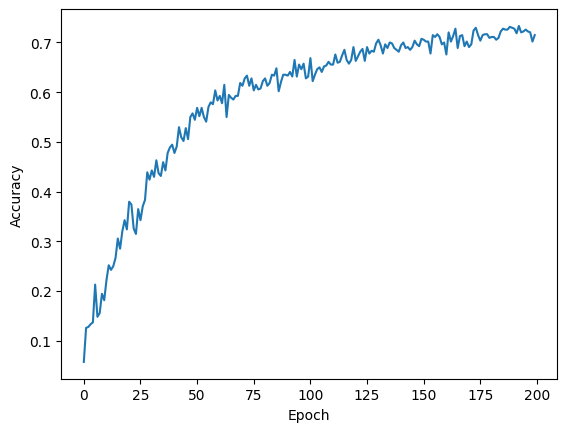

In [39]:
acc = history.history['accuracy']
print(acc)
plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
plt.show()


In [41]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(11,100,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dr, activation="tanh"),
])

model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[4].set_weights(model.layers[4].get_weights())



In [42]:
cluster_embeddings = model2.predict(w2v_embeddings)
print(cluster_embeddings.shape)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(540, 10)


In [43]:
dataset_not_padded = full_dataset("../data/gold_release.json")
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=42, n_init=100).fit(cluster_embeddings)
labels = kmeans.labels_
for i in range(15):
    print("Cluster ", i)
    for j in range(len(labels)):
        if labels[j] == i:
            print(dataset_not_padded[j])

Cluster  0
['back', 'rest', 'unserviceable', 'handle', 'broken']
['backlight', 'on', 'dash', 'unserviceable']
['batteries', 'discharging']
['compressor', 'oil', 'pressure', 'switch', 'unserviceable']
['control', 'valve', 'unserviceable', 'see', 'long', 'text']
['transmission', 'fill', '/', 'drain', 'plug', 'unserviceable']
['rear', 'through', 'shaft', 'universal', 'joint', 'unserviceable']
['rear', 'wiper', 'motor', 'unserviceable']
['replace', 'unserviceable', 'differential', 'drain', 'plugs']
['right', 'hand', 'bobbin', 'roller', 'unserviceable']
['cabin', 'seat', 'unserviceable', 'needs', 'replacing']
['replace', 'blocked', 'dryer']
['[', 'shutdown', ']', 'vinyl', 'flooring', 'unserviceable']
['battery', 'unserviceable', 'dropped', 'cell', 'replace']
['generator', 'flow', 'regulator', 'unserviceable']
['left', 'hand', 'chain', 'guide', 'unserviceable']
['left', 'hand', 'PTO', 'pump', 'chip', 'sensor', 'harness', 'unserviceable']
['number', 'pump', 'contamination', 'switch', 'on']
['

## Hierachical Clustering

### Average clustering

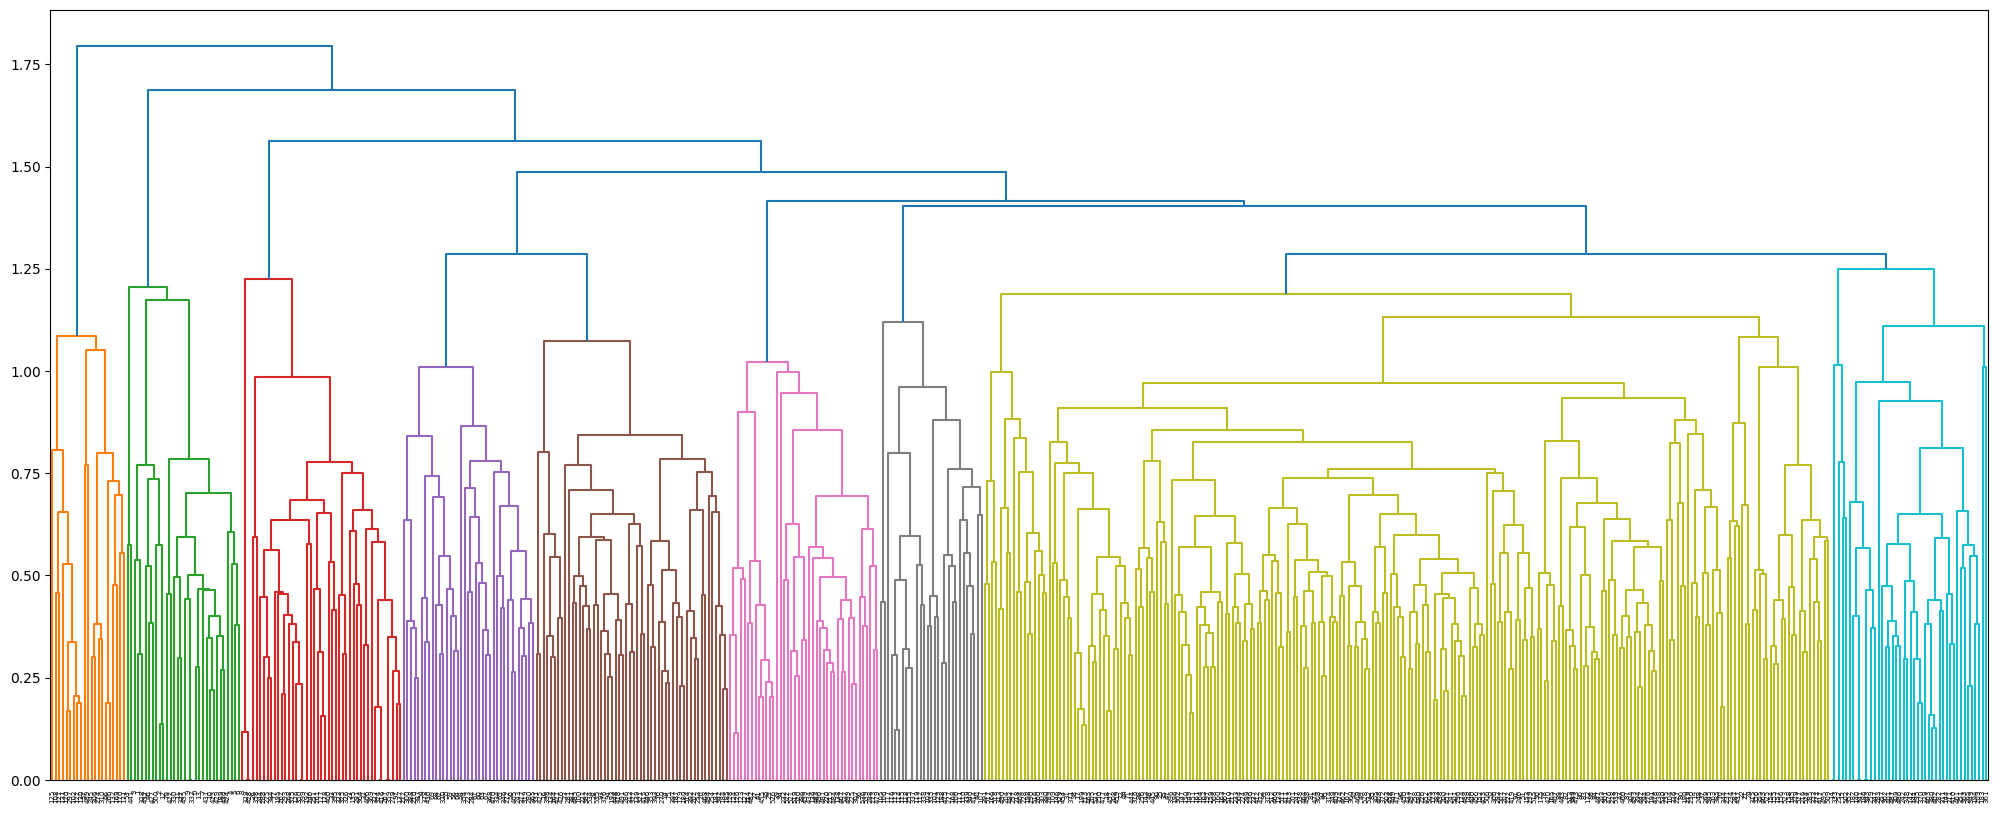

In [44]:
linkage_data = linkage(cluster_embeddings, method='average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [51]:
k=15
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
air leak
air leak
Top words:
air
leak

Cluster 2 :
blown position tyre
change out blown position tyre
change out cracked position adaptor and tooth
change out position and tyre worn out
change out position tyre sensor not reading
change out position tyre damage
change out unserviceable position tyre
change out worn position tyre
change position flat tyre
change position tyre damage text
damage to position tyre
damaged position tyre
damaged position tyre and rim
replace damaged position tyre and position
position tyre blown
replace damaged tyre on position
change out position tyre worn
replace position tyre damaged
replace position tyre mismatched
Top words:
position
tyre
change
out
damaged

Cluster 3 :
change out broken prelube bracket
change out broken stabilizer bar
Top words:
change
out
broken
prelube
bracket

Cluster 4 :
blown air conditioner hose
blown air conditioner fuse
Top words:
blown
air
conditioner
hose
fuse

Cluster 5 :
air conditioner thermostat unserviceable


### ward clustering

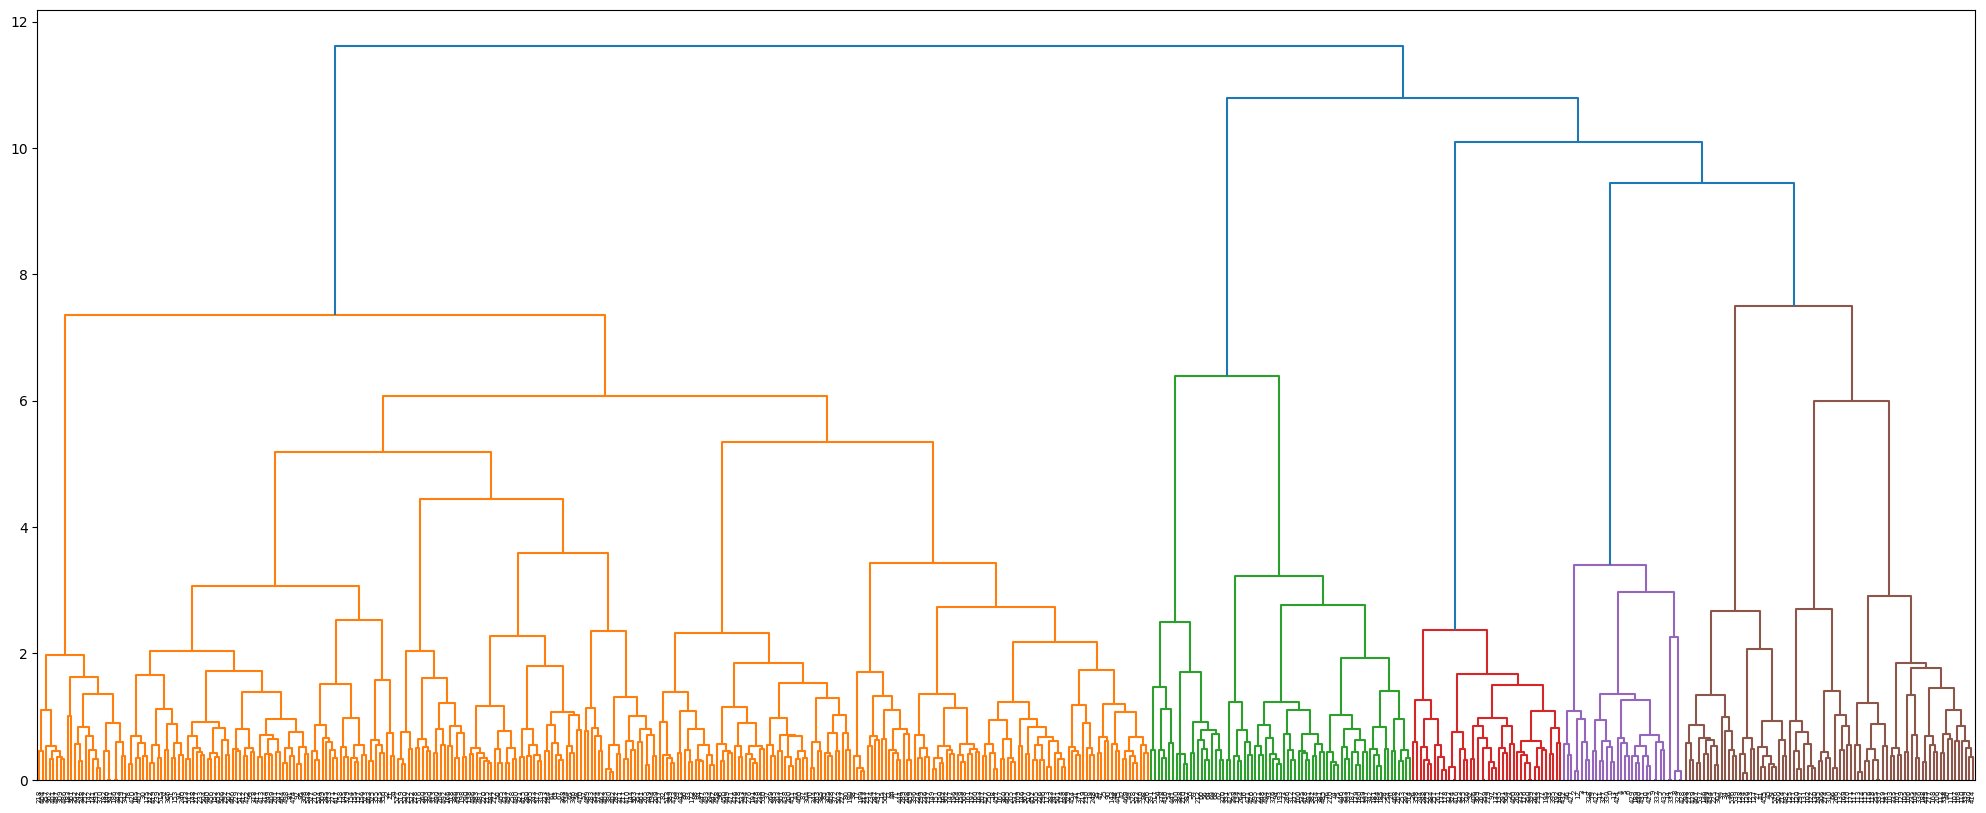

In [46]:
linkage_data = linkage(cluster_embeddings, method='ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [48]:
k=5
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
air leak near side of door
airhorn not working
alarm on VIMS does not work
all dash lights on
alternator failed
alternator not charging
alternator overcharged
analyse failed driveline component
auto-lube error PO
auto-spray feature not working
backhoe windscreen to be fixed
backlights on dash blown
backup alarm not working
battery cover hinges seized
beacon mount is broken
beacon not working
bearings are shot
belly plate bolt missing
bent belly plate
blade light blown needs replacing
blade skin cracked
blade wear plates cracked and worn
blown extension line from position
blown hose in hitch
blown light on boom
blown o-ring on left hand lift cylinder
blown oil cooler hose x metre
blown right hand bucket cylinder hose
boarding gate hinge broken
boarding gate latch not working
boarding ladder not working
brake temperature error
broken clamp on crowd cylinder hose TBC
broken fuel cooler mounts
broken grease plug
broken hinge
broken joystick PO
broken left hand side mirror
broke

### centroid clustering

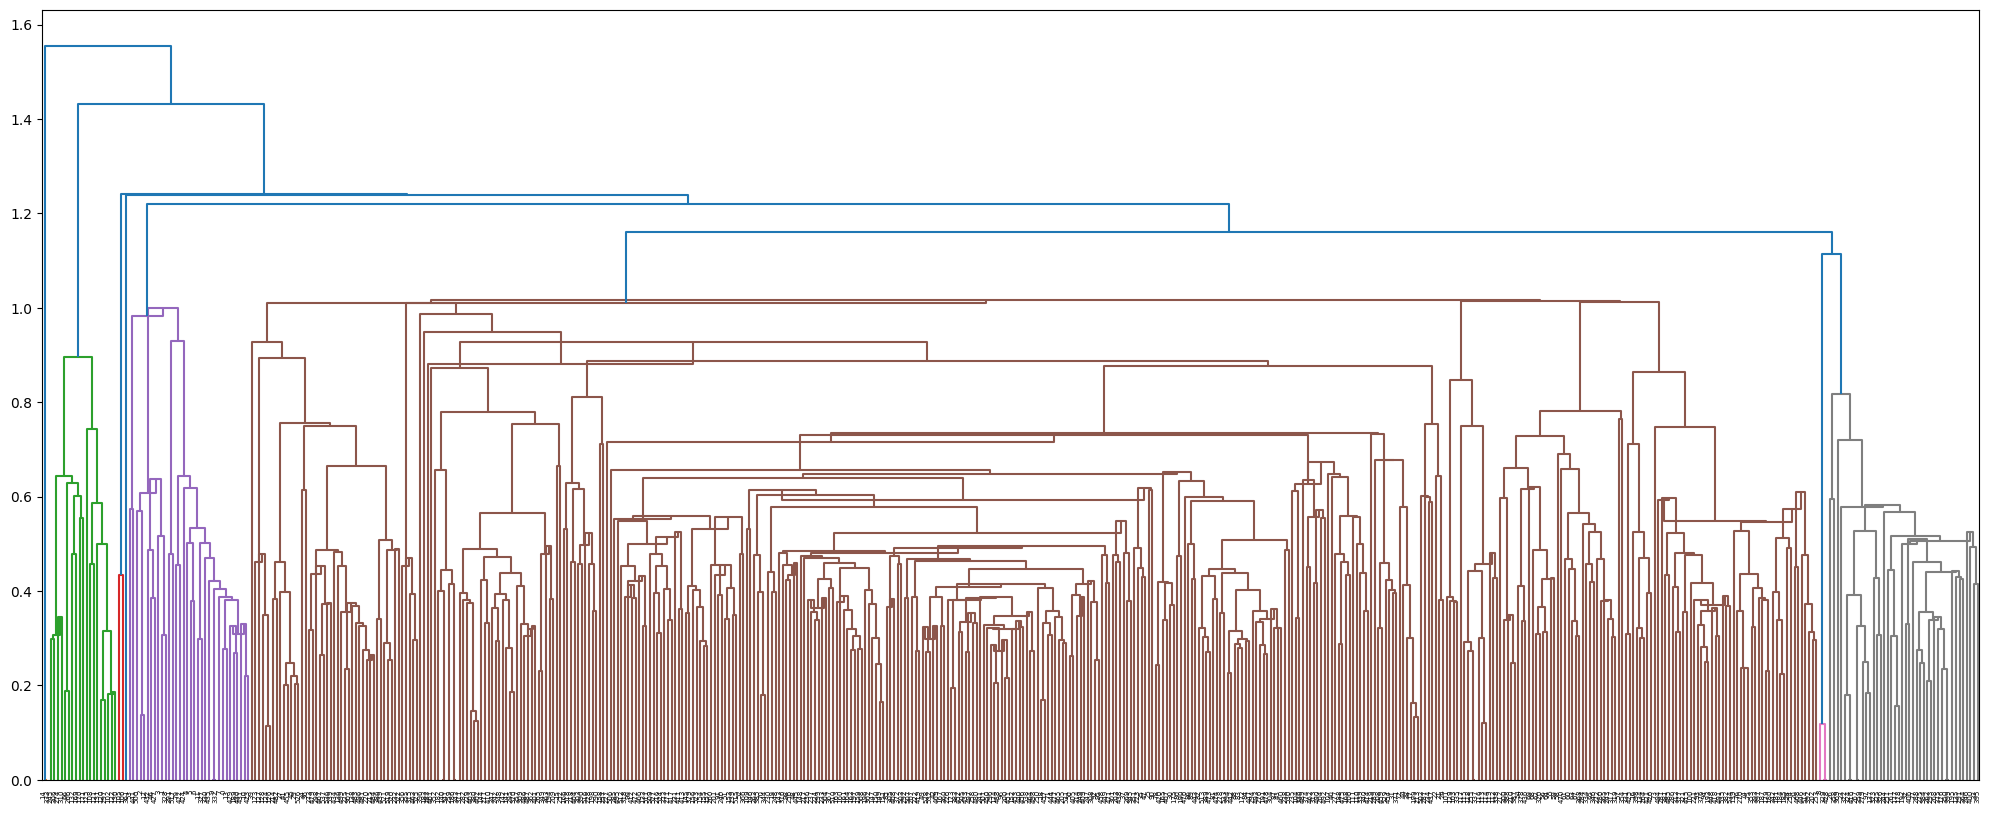

In [49]:
linkage_data = linkage(cluster_embeddings, method='centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [50]:
k=8
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
air leak
air leak
Top words:
air
leak

Cluster 2 :
blown position tyre
change out blown position tyre
change out cracked position adaptor and tooth
change out position and tyre worn out
change out position tyre sensor not reading
change out position tyre damage
change out unserviceable position tyre
change out worn position tyre
change position flat tyre
change position tyre damage text
damage to position tyre
damaged position tyre
damaged position tyre and rim
replace damaged position tyre and position
position tyre blown
replace damaged tyre on position
change out position tyre worn
replace position tyre damaged
replace position tyre mismatched
Top words:
position
tyre
change
out
damaged

Cluster 3 :
change out broken prelube bracket
change out broken stabilizer bar
Top words:
change
out
broken
prelube
bracket

Cluster 4 :
air conditioner thermostat not working
air conditioner thermostat unserviceable
air conditioner unserviceable
air conditioner unserviceable when statio

# Inherent Function dataset

## CNN

In [82]:
dataset2 = full_dataset_append_inherent_functions("../data/gold_release.json")
print(dataset2)
pad_sequence(dataset2)
print(len(dataset2))

[['air', 'conditioner', 'thermostat', 'not', 'working', 'emitting', 'sensing'], ['air', 'conditioner', 'thermostat', 'unserviceable', 'emitting', 'sensing'], ['air', 'conditioner', 'unserviceable', 'emitting'], ['air', 'conditioner', 'unserviceable', 'when', 'stationary', 'emitting'], ['air', 'conditioner', 'warm', 'emitting'], ['air', 'filters', 'plugged', 'matterprocessing'], ['air', 'horn', 'disconnected', 'presenting'], ['air', 'horn', 'does', 'not', 'work', 'presenting'], ['air', 'horn', 'fault', 'presenting'], ['air', 'horn', 'not', 'working', 'presenting'], ['air', 'horn', 'not', 'working', 'compressor', 'awaiting', 'presenting', 'generating'], ['air', 'horn', 'stuck', 'on', 'presenting'], ['air', 'horn', 'unserviceable', 'presenting'], ['air', 'horn', 'working', 'intermittently', 'presenting'], ['air', 'leak'], ['air', 'leak', 'near', 'side', 'of', 'door', 'controlling'], ['air', 'leaking', 'from', 'line', 'outside', 'guiding'], ['airhorn', 'not', 'working', 'presenting'], ['al

In [83]:
# Word2Vec embeddings as input
w2vmodel = gensim.models.Word2Vec(dataset2, min_count=1, vector_size=100,
                                window=5, sg=1)
w2v_embeddings = []
for sentence in dataset2:
    row = []
    for word in sentence:
        row.append(w2vmodel.wv[word])
    w2v_embeddings.append(row)
w2v_embeddings = np.array(w2v_embeddings)

In [84]:
print(w2v_embeddings.shape)
shape = w2v_embeddings.shape
w2v_embeddings=w2v_embeddings.reshape(shape[0], shape[1], shape[2], 1)
print(w2v_embeddings.shape)


(540, 13, 100)
(540, 13, 100, 1)


In [85]:
# LSI embeddings as output
dictionary = gensim.corpora.Dictionary(dataset2)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dataset2]
lsamodel = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
concepts = list(lsamodel[doc_term_matrix])
lsa_embeddings=[]
for i in concepts:
    row = []
    for j in i:
        row.append(j[1])
    lsa_embeddings.append(row)
lsa_embeddings = np.array(lsa_embeddings)

In [86]:
print(lsa_embeddings.shape)
print(lsa_embeddings)

(540, 10)
[[ 2.10364807e+00 -2.56512535e+00 -1.42459024e+00 ...  1.37429693e-03
   1.12118309e-01  1.73611628e-01]
 [ 2.65503843e+00 -2.94509307e+00 -1.62368501e+00 ... -3.93381669e-01
  -4.44127283e-01  5.56356956e-01]
 [ 3.59692754e+00 -4.02874286e+00 -2.32153931e+00 ... -2.47619951e-01
  -6.66404144e-01  7.32072403e-01]
 ...
 [ 5.99200316e-01 -4.08415225e-01 -3.19278322e-01 ... -6.12760598e-01
  -8.33024082e-01  3.54166374e-01]
 [ 6.09743102e-01  2.23694414e-01  7.05402237e-01 ...  8.15732583e-01
  -4.97529397e-01  7.42482719e-01]
 [ 1.06821125e+00 -3.32858201e-01  6.76353584e-01 ... -1.07168947e+00
  -9.72885835e-01  2.00783291e-01]]


In [87]:
dr = 10
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(13,100,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dr, activation="tanh"),
    tf.keras.layers.Dense(units=10, activation="tanh")
])


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [88]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 13, 100, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 50, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 6, 50, 8)       │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │        24,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,720 (96.56 KB)

 Trainable params: 24,720 (96.56 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanSquaredLogarithmicError("sum_over_batch_size"),
              metrics=['accuracy'])

history = model.fit(w2v_embeddings, lsa_embeddings, epochs=200)


Epoch 1/200


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3359 - loss: 0.1593
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3753 - loss: 0.1203
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3818 - loss: 0.1106
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3914 - loss: 0.1103
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3671 - loss: 0.1136
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3614 - loss: 0.1145
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3883 - loss: 0.1098
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3723 - loss: 0.1149
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3841 - loss: 0.1097
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3722 - loss: 0.1096
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4099 - loss: 0.1097
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3855 - lo

[0.3629629611968994, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3777777850627899, 0.3870370388031006, 0.38148146867752075, 0.37962964177131653, 0.38148146867752075, 0.38333332538604736, 0.39259257912635803, 0.3870370388031006, 0.3888888955116272, 0.4055555462837219, 0.40740740299224854, 0.40925925970077515, 0.4185185134410858, 0.4148148000240326, 0.4185185134410858, 0.42407408356666565, 0.42592594027519226, 0.442592591047287, 0.4407407343387604, 0.43518519401550293, 0.43518519401550293, 0.44999998807907104, 0.43703705072402954, 0.4462963044643402, 0.46481481194496155, 0.45370370149612427, 0.459

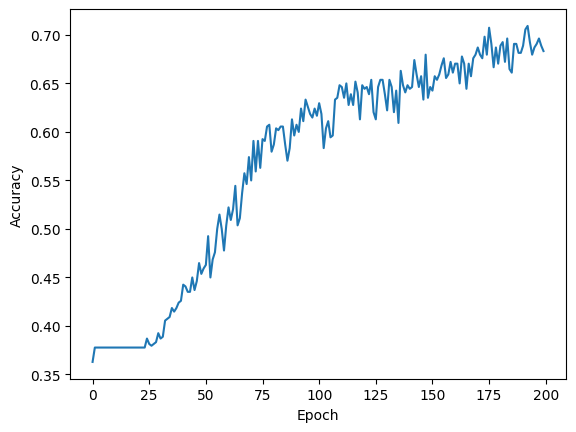

In [90]:
acc = history.history['accuracy']
print(acc)
plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
plt.show()


In [91]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(13,100,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dr, activation="tanh"),
])

model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[4].set_weights(model.layers[4].get_weights())



In [92]:
cluster_embeddings = model2.predict(w2v_embeddings)
print(cluster_embeddings.shape)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
(540, 10)


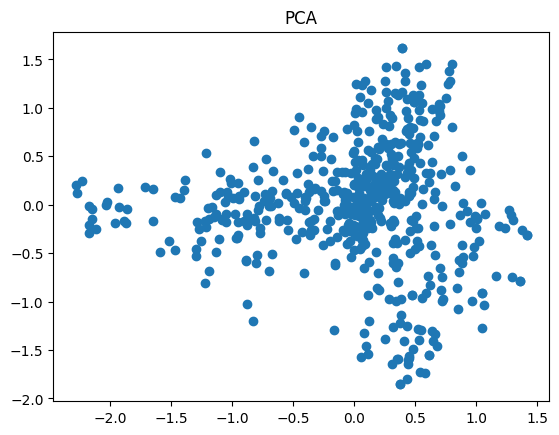

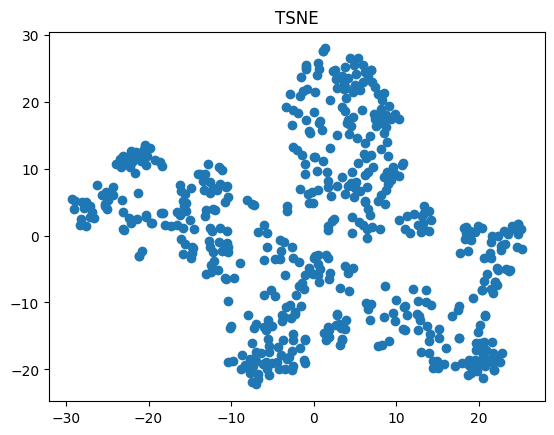

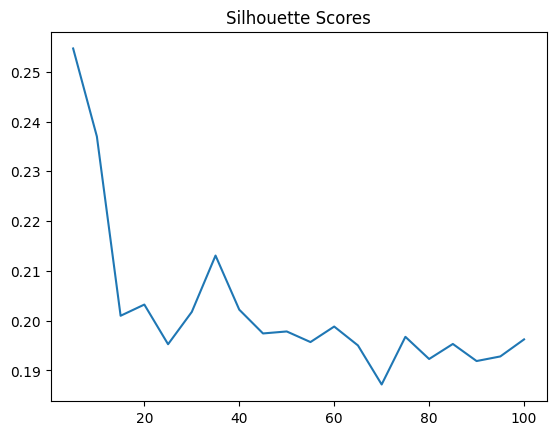

In [109]:
dataset_not_padded = full_dataset("../data/gold_release.json")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


# PCA reduction
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(cluster_embeddings)
plt.scatter(pca_embedding[:,0], pca_embedding[:,1])
plt.title("PCA")
plt.show()

# tsne reduction
tsne = TSNE(n_components=2).fit_transform(cluster_embeddings)
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("TSNE")
plt.show()


# Perform kmean clustering
silhouette_scores = []
test_k = list(range(5, 105, 5))
for i in test_k:
    print(i, "/", 100)
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=100).fit(cluster_embeddings)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(cluster_embeddings, labels))
plt.plot(test_k, silhouette_scores)
plt.title("Silhouette Scores")
plt.show()


In [110]:
# best k
k = 25
kmeans = KMeans(n_clusters=k, random_state=42, n_init=100).fit(cluster_embeddings)

for i in range(k):
    print("Cluster ", i)
    for j in range(len(labels)):
        if labels[j] == i:
            print(dataset_not_padded[j])
            
    print()

Cluster  0
['differential', 'leak']
['differential', 'oil', 'leak']
['replace', 'oil', 'leaks']
['oil', 'leak', 'swingbox']
['differential', 'oil', 'leak']
['fuel', 'leak']
['minor', 'transmission', 'oil', 'leak']
['oil', 'leak', 'pilot', 'filter', 'text']
['repair', 'transmission', 'oil', 'leak', 'text']
['replace', 'hydraulic', 'oil', 'leak', 'text']
['oil', 'leak', 'at', 'diverter', 'valve']

Cluster  1
['all', 'dash', 'lights', 'on']
['backlight', 'on', 'dash', 'unserviceable']
['beacon', 'unserviceable']
['microwave', 'oven', 'unserviceable']
['radiator', 'sight', 'glasses', 'unserviceable']
['siren', 'unserviceable']
['weightometer', 'display', 'on', 'trailer', 'unserviceable']

Cluster  2
['replace', 'broken', 'onside', 'mirror']
['replace', 'broken', 'earth', 'terminal']

Cluster  3
['blade', 'skin', 'cracked']
['crack', 'onside', 'rock', 'deflector']
['dust', 'leak', 'operators', 'side', 'window']
['handrail', 'above', 'battery', 'box', 'cracked']
['faulty', 'fuel', 'pressure'

## Hierachical Clustering

In [126]:
def silhouette(type, embeddings):
    silhouette_scores = []
    test_k = list(range(5, 105, 5))
    linkage_data = linkage(embeddings, method=type)
    for i in test_k:
        # print(i, "/", 100)
        cluster_labels = fcluster(linkage_data, i, criterion='maxclust')
        silhouette_scores.append(silhouette_score(embeddings, cluster_labels))
    plt.plot(test_k, silhouette_scores)
    plt.title("Silhouette Scores")
    plt.show()

### Average clustering

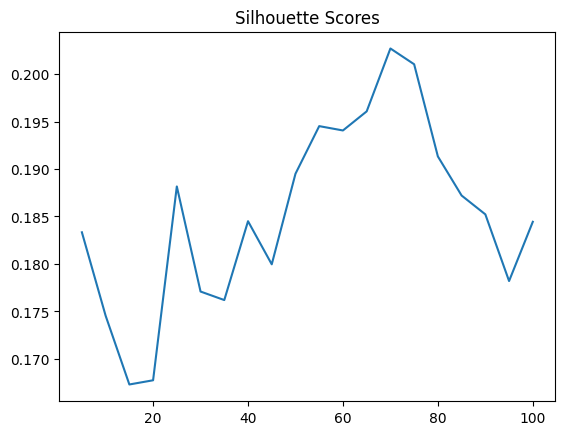

In [127]:
silhouette('average', cluster_embeddings)

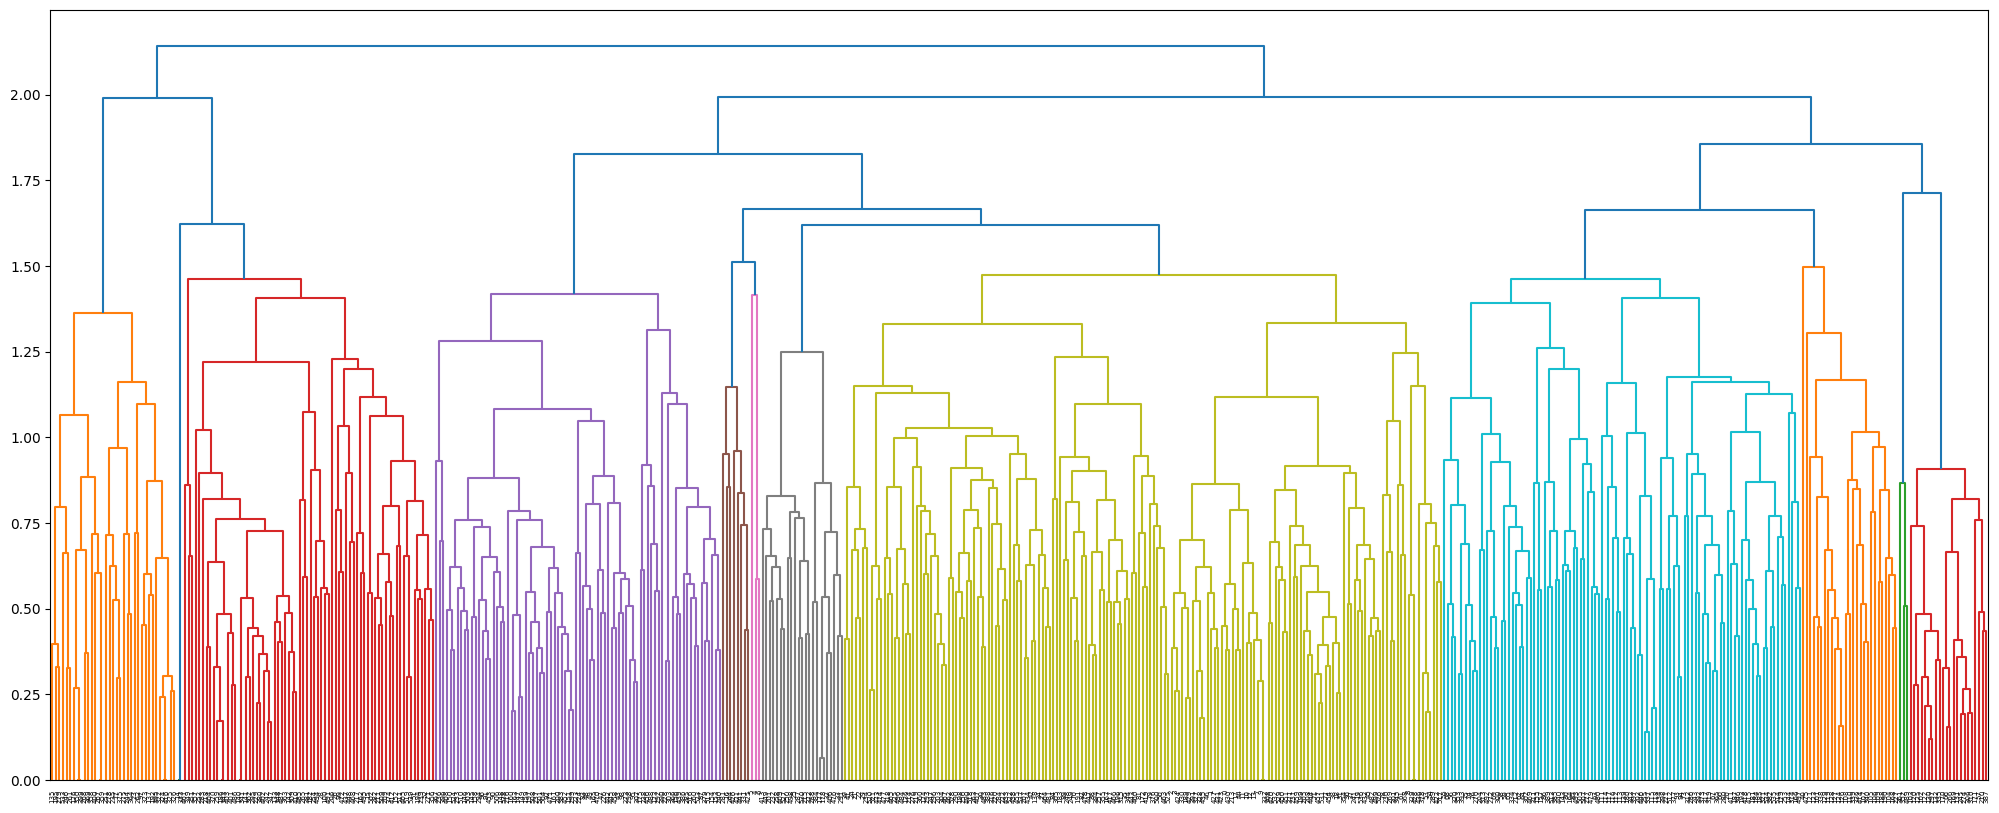

In [95]:
linkage_data = linkage(cluster_embeddings, method='average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [129]:
k=12
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset2[j]))
            for word in set(dataset2[j]):
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
blown position tyre guiding blown position tyre guiding blown position tyre guiding blown
change out blown position tyre guiding change out blown position tyre guiding change
change out blown steering hose guiding controlling change out blown steering hose guiding
change out position and tyre worn out guiding change out position and tyre
change out position tyre damage guiding change out position tyre damage guiding change
change out unserviceable position tyre guiding change out unserviceable position tyre guiding change
change out worn position tyre guiding change out worn position tyre guiding change
change position flat tyre guiding change position flat tyre guiding change position flat
change position tyre damage text guiding change position tyre damage text guiding change
damage to position tyre guiding damage to position tyre guiding damage to position
damaged position tyre guiding damaged position tyre guiding damaged position tyre guiding damaged
damaged position t

### ward clustering

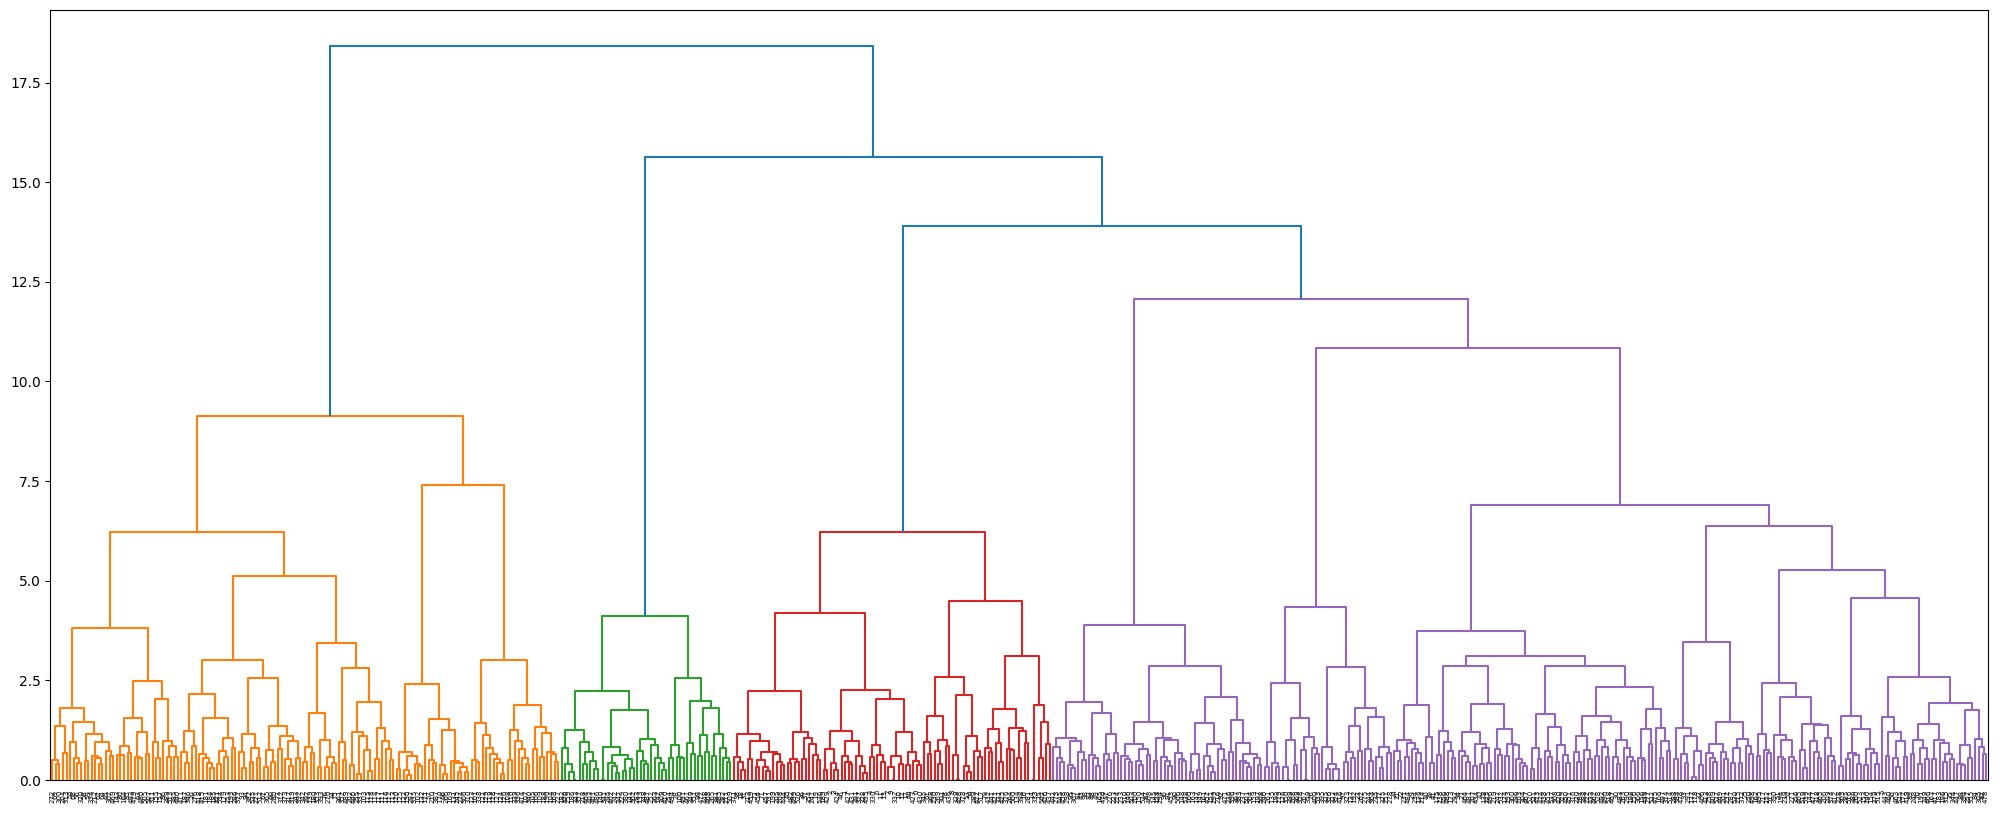

In [97]:
linkage_data = linkage(cluster_embeddings, method='ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [99]:
k=6
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
alternator drive leaking
blown brake hose
blown crowd cylinder hose
blown extension line from position
blown hose in hitch
blown hose on boom
blown lift cylinder o-ring
blown o-ring off steering hose
blown o-ring on left hand lift cylinder
blown o-ring on steering hose
blown oil cooler hose x metre
blown position tyre
blown right hand bucket cylinder hose
blown steering hose
blown steering pump hose
both stick cylinders leaking
brake cooling hose leaking
brake cooling hose leaking rear
brake cooling return hose leaking
broken clamp on crowd cylinder hose TBC
broken left hand side mirror
broken mirror
cabin seals leaking dust PO
cabin seals leaking dust bad
change out blown o-ring on steering pump
change out blown position tyre
change out blown steering hose
change out broken bolt on brake pump
change out broken prelube bracket
change out broken stabilizer bar
change out cracked pipe on valve bank
change out cracked position adaptor and tooth
change out exhaust clamp broken 

### centroid clustering

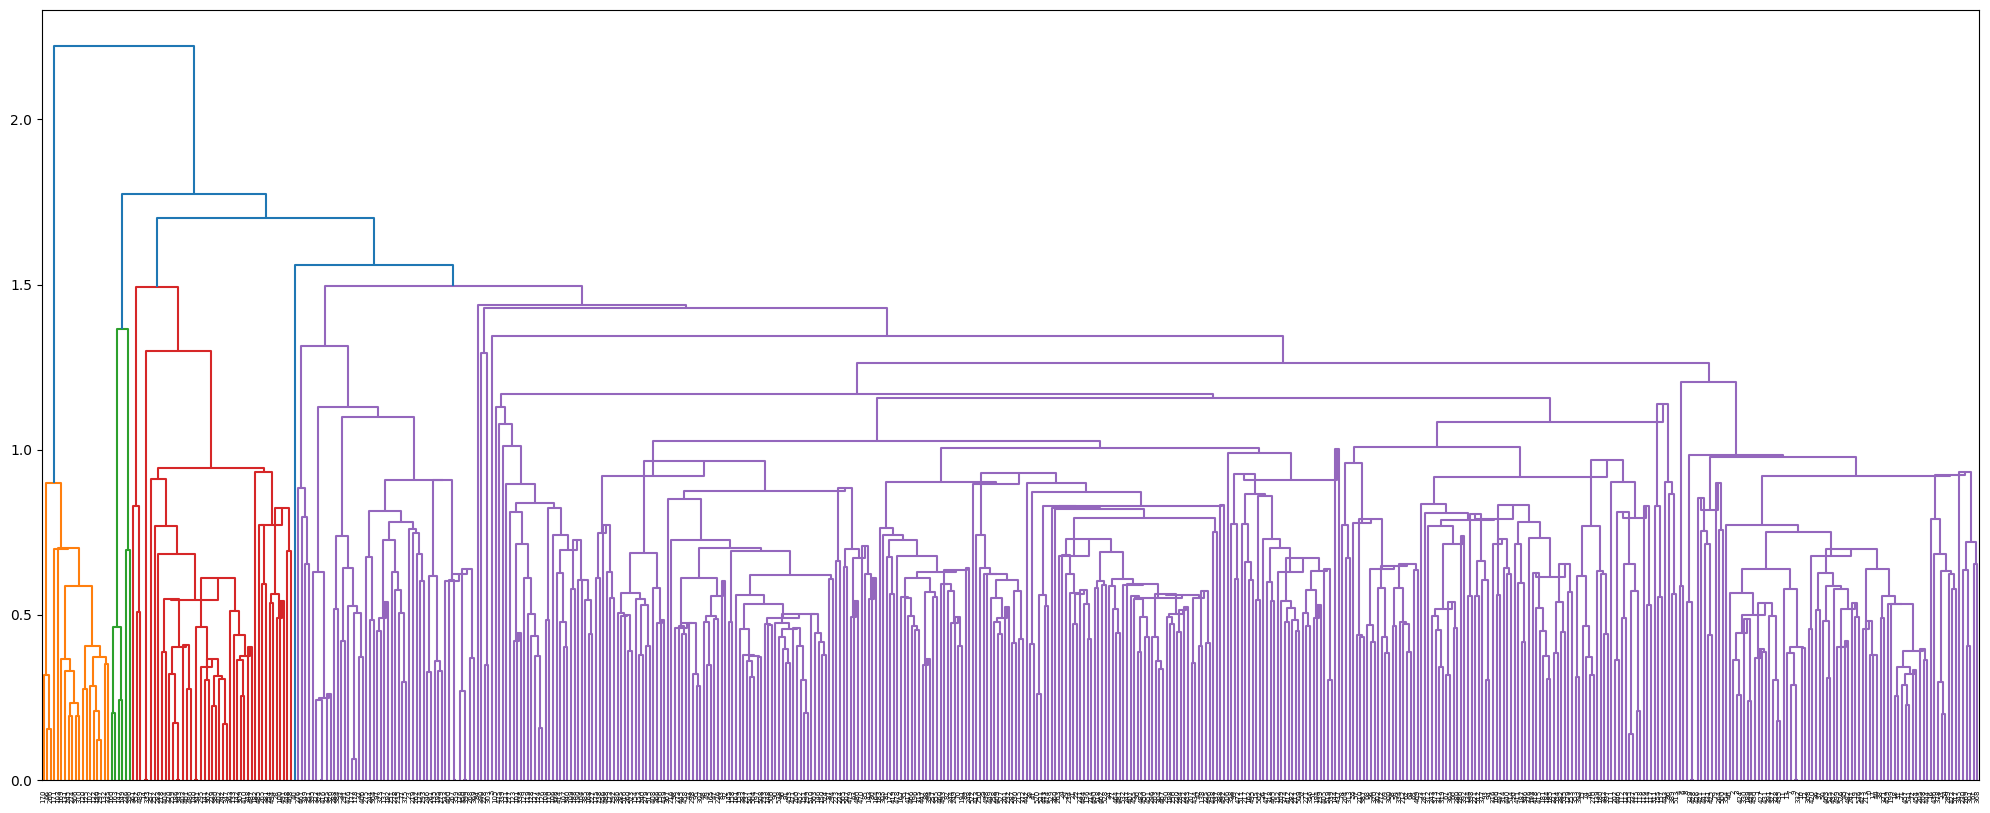

In [100]:
linkage_data = linkage(cluster_embeddings, method='centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [101]:
k=5
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
blown position tyre
change out blown position tyre
change out blown steering hose
change out position and tyre worn out
change out position tyre damage
change out unserviceable position tyre
change out worn position tyre
change position flat tyre
change position tyre damage text
damage to position tyre
damaged position tyre
damaged position tyre and rim
replace damaged position tyre and position
position tyre blown
replace damaged tyre on position
change out position tyre worn
replace position tyre damaged
replace position tyre mismatched
change out blown hose
Top words:
position
tyre
change
out
blown

Cluster 2 :
crack in boom chord
crack in headboard
cracks in decking
cracks in headboard
repair cracks on stick
stick cracks
Top words:
in
cracks
crack
headboard
stick

Cluster 3 :
air leak
auto-greaser leaking oil
centrifugal oil filter leaking
check / repair engine oil leak
coolant leak
coolant leak at engine oil cooler
coolant leak at jacket water pump
differential leak
di

# maintIE inherent function clusters

In [147]:
def get_inherent_function(row):
    functions = []
    for e in row["entities"]:
        entity_type = e["type"].split("/")
        if entity_type[0] == "PhysicalObject":
            if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                if entity_type[1][:-6].lower() not in functions:
                    functions.append(entity_type[1][:-6].lower())
    functions = ",".join(sorted(functions))
    return functions

f = open("../data/gold_release.json", "r")
# returns JSON object as a dictionary
data = json.load(f)
f.close()

MWO_by_function = {}

for datum in data:
    types = [e["type"].split("/")[0] for e in datum["entities"]]
    if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
        inherent_functions = get_inherent_function(datum)
        tokens = clean_tokens(datum["tokens"])
        if inherent_functions in MWO_by_function:
            MWO_by_function[inherent_functions].append(tokens)
        else:
            MWO_by_function[inherent_functions] = [tokens]

print(len(MWO_by_function.keys()))
for i in MWO_by_function.keys():
    print(i, len(MWO_by_function[i]))
    if len(MWO_by_function[i]) == 1:
        print("   ", MWO_by_function[i])


121
emitting,sensing 3
emitting 23
matterprocessing 21
presenting 19
generating,presenting 3
 7
controlling 22
guiding 44
driving,generating 1
    [['alternator', 'drive', 'leaking']]
generating 22
transforming 23
protecting 24
storing 14
generating,protecting 5
sensing,transforming 3
humaninteraction,storing 1
    [['back', 'rest', 'unserviceable', 'handle', 'broken']]
controlling,matterprocessing 1
    [['backhoe', 'windscreen', 'to', 'be', 'fixed']]
emitting,presenting 3
covering,generating,holding 1
    [['battery', 'cover', 'hinges', 'seized']]
emitting,holding 4
emitting,generating,holding 1
    [['bearing', 'on', 'air', 'conditioner', 'compressor', 'unserviceable']]
holding 34
emitting,matterprocessing 1
    [['blade', 'light', 'blown', 'needs', 'replacing']]
matterprocessing,protecting 5
emitting,guiding 8
guiding,restricting 7
driving,guiding 8
guiding,interfacing 1
    [['blown', 'hose', 'in', 'hitch']]
guiding,holding 5
covering,driving 2
controlling,covering,guiding 2
contr